In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
import tools
from math import sqrt
from script.tools import tools
#from script.collection import Parameter as pmt
import sys
print(sys.executable)
import net
import os
from script.tools import collection
#result = collection.collection("collection/workspace1")  #[iops,dic_ssd,dic_worload,f.path]
#result = collection.collection("collection/workspace2",result)
result = collection.collection("collection/workspace_ssd0_workload0")
#result = result[:1000]
plst = collection.getParameters(path="collection/config.xlsx",id = "0")
expect = ['Seed','key','default']

/opt/homebrew/anaconda3/bin/python
no scenario collection/workspace_ssd0_workload0/1854/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/425/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/866/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/1994/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/1702/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/428/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/3472/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/1796/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/2148/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/2918/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/3981/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/2456/workload_scenario_1.xml
no scenario collection/workspace_ssd0_worklo

/opt/homebrew/anaconda3/lib/python3.9/site-packages/openpyxl/reader/excel.py:237: UserWarning: Data Validation extension is not supported and will be removed
  ws_parser.bind_all()


In [2]:
result = result[:1000]
def test(x_,y_,m, mean = 0,std = 1):
    x_ = (x_ - mean)/std
    y_pre = m(x_)
    y_e = abs(y_pre - y_)/y_
    print(torch.sum(y_e)/len(y_))

In [3]:
#print(result[0])
from script.tools import collection
split_index = int(len(result)*0.7)
train_result = result[:split_index]
test_result  = result[split_index:]
x_train_lst, y_train_lst, keys = collection.result2lst(train_result,plst,expect)
x_test_lst,  y_test_lst, keys = collection.result2lst(test_result,plst,expect)
x_train_tensor = torch.tensor(  x_train_lst  , dtype=torch.float)
y_train_tensor = torch.tensor(  y_train_lst  , dtype=torch.float)/10000
x_test_tensor =  torch.tensor(  x_test_lst   , dtype=torch.float)
y_test_tensor =  torch.tensor(  y_test_lst   , dtype=torch.float)/10000
x_mean = x_train_tensor.mean(dim = 0)
x_std = x_train_tensor.std(dim = 0)
x_train_tensor_nor = (x_train_tensor -x_mean)/x_std

dataset = collection.CustomDataset(x_train_tensor_nor, y_train_tensor)
batch_size = 5
dataloader = collection.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = net.DeepNet(19,8,1,5)
criterion = nn.MSELoss()
print(len(keys))
print(keys)

19
['Overprovisioning_Ratio', 'Flash_Channel_Count', 'Channel_Transfer_Rate', 'Chip_No_Per_Channel', 'Page_Read_Latency_LSB', 'Page_Read_Latency_MSB', 'Page_Program_Latency_LSB', 'Page_Program_Latency_MSB', 'Die_No_Per_Chip', 'Plane_No_Per_Die', 'Block_No_Per_Plane', 'Page_No_Per_Block', 'Channel_IDs', 'Chip_IDs', 'Die_IDs', 'Plane_IDs', 'Initial_Occupancy_Percentage', 'Working_Set_Percentage', 'Read_Percentage']


In [6]:
print(x_train_tensor_nor.shape,y_train_tensor.shape)

torch.Size([700, 19]) torch.Size([700, 1])


In [4]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 400
lambda_l2 = 2e-6
loss_history = []
for epoch in range(num_epochs):
    total_loss = 0.0
    i = 0
    for batch_x, batch_y in dataloader:
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        l2_regularization = torch.tensor(0.)
        for param in model.parameters():
            l2_regularization += torch.norm(param, p=2)
            loss = loss + l2_regularization * lambda_l2
        i = i + 1
        if i == -1:
            print("i=------"+str(i),"\n outputs: ",outputs,"\n y:",batch_y)
        total_loss += loss.item()
        if False:
            print("   \n \n")
            print(" outputs: ", outputs)
            print(" batch_y", batch_y)
            print(" loss ", loss)
            print("   \n \n")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 100 == 0:
        average_loss = total_loss / len(dataloader)
        #print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.6f}')
        print("test:")
        test(x_test_tensor,y_test_tensor,model,x_mean,x_std) # test准确度
print("final_train")
# 训练：y和正则化后的x(x_train_tensor_nor)  测试时，将x_train_tensor减均值除以方差后放入model
test(x_train_tensor,y_train_tensor,model,x_mean,x_std)
print("\n \n final_test:")
test(x_test_tensor,y_test_tensor,model,x_mean,x_std) # test

Epoch [100/400], Loss: 0.012601
test:
tensor(0.2727, grad_fn=<DivBackward0>)
Epoch [200/400], Loss: 0.005367
test:
tensor(0.2482, grad_fn=<DivBackward0>)
Epoch [300/400], Loss: 0.003773
test:
tensor(0.2227, grad_fn=<DivBackward0>)
Epoch [400/400], Loss: 0.002815
test:
tensor(0.2066, grad_fn=<DivBackward0>)
final_train
tensor(0.1417, grad_fn=<DivBackward0>)

 
 final_test:
tensor(0.2066, grad_fn=<DivBackward0>)


In [5]:

# 训练集
print("train")
test(x_train_tensor,y_train_tensor,model,x_mean,x_std)
print("\n \n test:")
test(x_test_tensor,y_test_tensor,model,x_mean,x_std) # test
#print(x_train_tensor[0],model(x_train_tensor_nor[0]),y_train_tensor[0])
print("\n \n")

id = 20
print("out:",y_test_tensor[id])
print(model( (x_test_tensor-x_mean)/x_std )[id])


train
tensor(0.1417, grad_fn=<DivBackward0>)

 
 test:
tensor(0.2066, grad_fn=<DivBackward0>)

 

out: tensor([0.9519])
tensor([0.8932], grad_fn=<SelectBackward0>)


In [191]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. 定义cGAN的结构
class Generator(nn.Module):
    def __init__(self, output_dim=19, noise_dim=5, condition_dim=1):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + condition_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, output_dim)
        )

    def forward(self, y, noise):
        combined = torch.cat([y, noise], dim=1)
        return self.model(combined)

class Discriminator(nn.Module):
    def __init__(self, input_dim=19, condition_dim=1):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=1)
        return self.model(combined)

In [192]:
import matplotlib.pyplot as plt
losses_fake = []
losses_real = []
losses_d = []
losses_g = []
epoch_total = 0

# 2. 训练cGAN
generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.005)


In [193]:
losses_fake = []
losses_real = []
losses_d = []
losses_g = []
epoch_total = 0

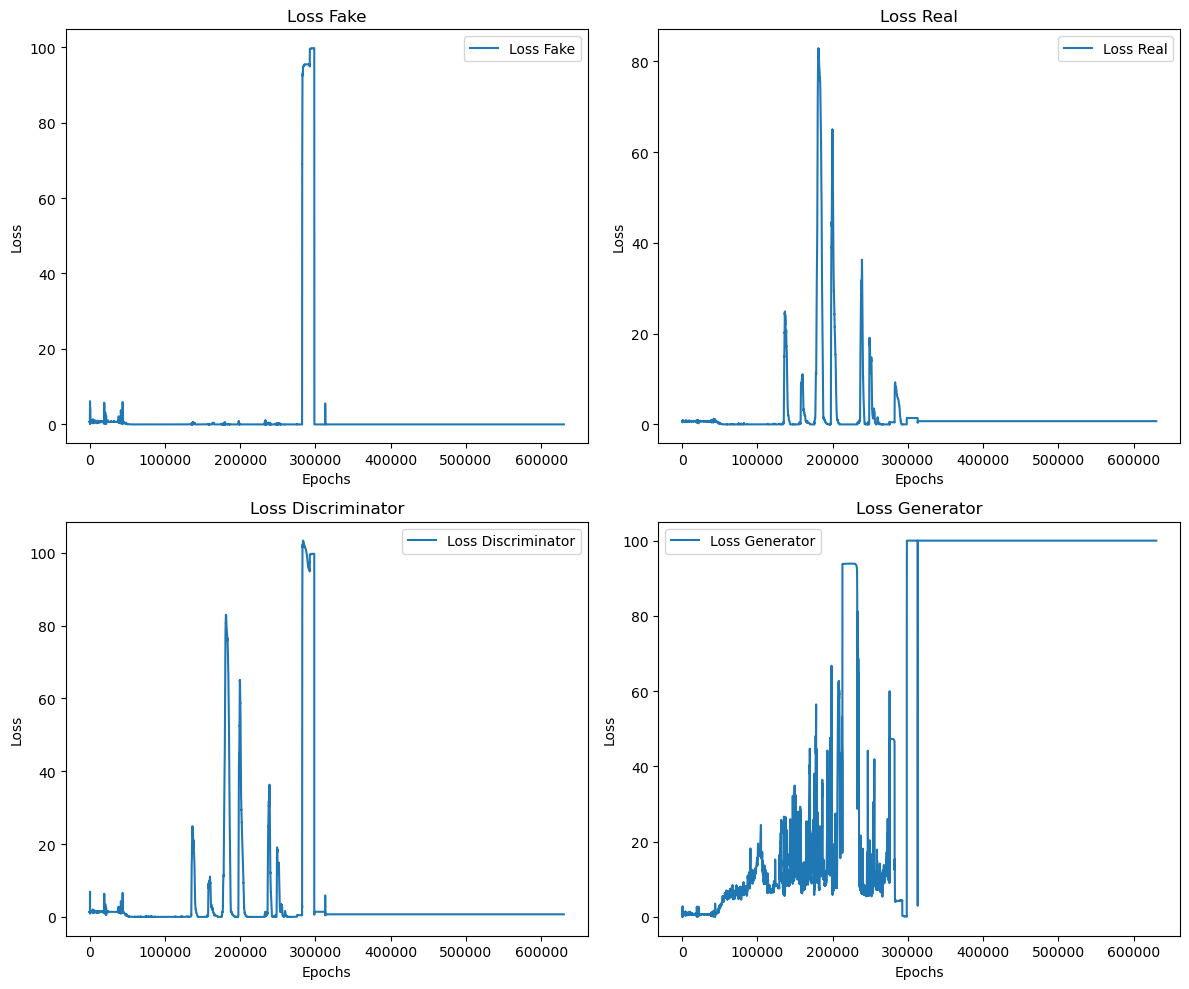

In [216]:
optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.005)
num_epochs = 40000  # 根据需要调整

for epoch in range(num_epochs):
    # Train Discriminator
    optimizer_d.zero_grad()
    noise = torch.randn(700, 5)
    fake_x = generator(y_train_tensor, noise)
    real_labels = torch.ones(700, 1)
    fake_labels = torch.zeros(700, 1)

    logits_real = discriminator(x_train_tensor_nor, y_train_tensor)
    logits_fake = discriminator(fake_x.detach(), y_train_tensor)
    loss_real = criterion(logits_real, real_labels)
    loss_fake = criterion(logits_fake, fake_labels)
    loss_d = loss_real + loss_fake

    loss_d.backward()
    optimizer_d.step()

    # Train Generator
    optimizer_g.zero_grad()

    logits_fake = discriminator(fake_x, y_train_tensor)
    loss_g = criterion(logits_fake, real_labels)
    loss_g.backward()
    optimizer_g.step()
    losses_fake.append(loss_fake.item())
    losses_real.append(loss_real.item())
    losses_d.append(loss_d.item())
    losses_g.append(loss_g.item())
# 绘制损失值
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].plot(losses_fake, label='Loss Fake')
axs[0, 0].set_title('Loss Fake')
axs[0, 1].plot(losses_real, label='Loss Real')
axs[0, 1].set_title('Loss Real')
axs[1, 0].plot(losses_d, label='Loss Discriminator')
axs[1, 0].set_title('Loss Discriminator')
axs[1, 1].plot(losses_g, label='Loss Generator')
axs[1, 1].set_title('Loss Generator')

for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Loss')
    ax.legend()

plt.tight_layout()
plt.show()

In [213]:
# 3. 使用生成器生成新的x_train_tensor
noise = torch.randn(700, 5)
x_generated = generator(y_train_tensor, noise)
#combined = torch.cat([y, noise], dim=1)
t = torch.cat([y_train_tensor,noise],dim = 1)
print(t.shape)
x_combined = torch.cat([x_train_tensor, x_generated], dim=0)
y_combined = torch.cat([y_train_tensor, y_train_tensor], dim=0)
k = 430
print(model((x_train_tensor[k]-x_mean)/x_std))
print(model(x_generated[k]))
#print(model((x_generated[k]-x_mean)/x_std))
print("y:",y_train_tensor[k])
print("test")

torch.Size([700, 6])
tensor([0.8898], grad_fn=<AddBackward0>)
tensor([3.3193], grad_fn=<AddBackward0>)
y: tensor([0.9726])
test


In [214]:
print(x_combined.shape,x_generated.shape,x_train_tensor.shape)

torch.Size([1400, 19]) torch.Size([700, 19]) torch.Size([700, 19])


In [215]:
print(x_train_tensor[0])
print(x_generated[0])

tensor([1.8117e-01, 8.0000e+00, 2.3620e+03, 2.0000e+00, 6.0913e+05, 1.6647e+05,
        4.0224e+06, 6.7864e+06, 1.0000e+00, 6.0000e+00, 7.1680e+03, 1.5360e+03,
        3.0000e+00, 2.0000e+00, 1.0000e+00, 6.0000e+00, 7.3000e+01, 2.2000e+01,
        4.1000e+01])
tensor([-1.5909, -0.8801, -1.3447,  0.8565, -0.8416, -1.3989, -2.0477, -1.3009,
        -2.3900, -0.7563, -1.8591,  1.3084, -0.8300,  1.7687, -1.5796, -0.6374,
        -0.1910,  0.3416,  1.3761], grad_fn=<SelectBackward0>)
